# Importo librerie

In [ ]:
# !pip install pyvis
# !pip install tweepy=="4.0.0"

     |████████████████████████████████| 60 kB 4.3 MB/s 
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [ ]:
import os
import json
import tweepy
import math
import pprint as pp
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms.distance_measures import center, radius
from networkx.algorithms.smallworld import omega,sigma
from networkx.algorithms.link_analysis.hits_alg import hits
import matplotlib.pyplot as plt
from pylab import rcParams
from pyvis.network import Network
from scipy import stats
import plotly.graph_objects as go


# Funzioni

## Classe Tutor

Gestisce ciò che riguarda grafici e metriche

In [ ]:
class Tutor:
    def __init__(self, root, api, client):
        self.infoDict = {}
        #pyvis
        self.generalGraph = Network()
        self.followerGraph = Network()
        self.friendGraph = Network()
        #networkx
        self.generalG = nx.DiGraph()
        self.followerG = nx.DiGraph()
        self.friendG = nx.DiGraph()
        #compente giganti
        self.generalGCG = nx.Graph()
        self.followersGCG = nx.Graph()
        self.friendsGCG = nx.Graph()

        self.memSort = []
        self.degreeCentralityGeneral = {}
        self.degreeCentralityFollowers = {}
        self.degreeCentralityFriends = {}

        self.betweennessCentralityGeneral = {}
        self.betweennessCentralityFollowers = {}
        self.betweennessCentralityFriends = {}

        self.closenessCentralityGeneral = {}
        self.closenessCentralityFollowers = {}
        self.closenessCentralityFriends = {}

        self.stronglyConnectedGraph = []
        self.bigComponentsLens = []
        self.bigComponentGraphNodes = []
        self.bigComponentsCenterNodes = []
        self.bigComponentsRadius = []
        self.bigComponentsAverageDist = []
        self.bigComponentsMaxDist = []

        self.pagerankGeneral = {}
        self.hubness = {}
        self.authority = {}
        self.clustering = {}

        self.omegaCoefficients = []
        self.sigmaCoefficients = []

        #creation of root nodes
        for name in root:
            t = Person(name, 0, api, client, self)
            t.tutor.addInfo(t.returnInfoDict())

    def drawDegreeDistributions(self):
        #raccolta frequenza dei degree
        listPossibleDegree = range(0,sorted(list(set([self.infoDict[id_]["object"].degree for id_ in self.infoDict])))[-1] +1)
        listFrequence0 = [0] * len(listPossibleDegree) #per il grafo generale
        listFrequence1 = [0] * len(listPossibleDegree) #per il grafo dei followers
        listFrequence2 = [0] * len(listPossibleDegree) #per il grafo dei friends
        for id_ in self.infoDict:
            listFrequence0[listPossibleDegree.index(self.infoDict[id_]["object"].degree)] += 1
            listFrequence1[listPossibleDegree.index(self.infoDict[id_]["object"].followersDegree)] += 1
            listFrequence2[listPossibleDegree.index(self.infoDict[id_]["object"].friendsDegree)] += 1

        figure, axis = plt.subplots(1,3)

        #distribuzione gradi grafo generale
        axis[0].bar(listPossibleDegree,listFrequence0)
        axis[0].set_title("generale")
        axis[0].set_xlabel("grado")
        axis[0].set_ylabel("n. nodi")

        #distribuzione gradi grafo followers
        axis[1].bar(listPossibleDegree,listFrequence1)
        axis[1].set_title("followers")
        axis[1].set_xlabel("grado")
        axis[1].set_ylabel("n. nodi")

        #distribuzione gradi grafo friends
        axis[2].bar(listPossibleDegree,listFrequence2)
        axis[2].set_title("friends")
        axis[2].set_xlabel("grado")
        axis[2].set_ylabel("n. nodi")
        plt.show()

    def analyzeGraphs(self):
        #creazione dei grafi
        generalG = nx.DiGraph(componente0 = "Mondin Roberto",
                              componente1 = "Cecchia Emanuele",
                              componente2 = "Comelli Tommaso",
                              componente3 = "Mian Lorenzo")
        followersG = nx.DiGraph(componente0 = "Mondin Roberto",
                                componente1 = "Cecchia Emanuele",
                                componenet2 = "Comelli Tommaso",
                                componente3 = "Mian Lorenzo")
        friendsG = nx.DiGraph(componente0 = "Mondini Roberto",
                              componente1 = "Cecchia Emanuele",
                              componente2 = "Comelli Tommaso",
                              componente3 = "Mian Lorenzo")

        #creazione dei nodi nei grafi
        listaID = [id_ for id_ in self.infoDict]
        for element in listaID:
            generalG.add_node(element,
                              id_ = element,
                              nome = self.infoDict[element]["object"].screen_name)
            followersG.add_node(element,
                                id_ = element,
                                nome = self.infoDict[element]["object"].screen_name)
            friendsG.add_node(element,
                              id = element,
                              nome = self.infoDict[element]["object"].screen_name)

        #creazione degli archi
        #follow -> output edge, friend -> input edge
        for element in listaID:
            #aggiunta archi followers
            for follower in self.infoDict[element]["object"].followersList:
                generalG.add_edge(element,follower)
                followersG.add_edge(element,follower)
                
            #aggiunta archi friends
            for friend in self.infoDict[element]["object"].friendsList:
                generalG.add_edge(friend,element)
                friendsG.add_edge(friend,element)

        self.generalG = generalG
        self.followerG = followersG
        self.friendG = friendsG

        #definizione pagerank
        self.pagerankGeneral = nx.pagerank(generalG)

        #definizione hubbness and authority
        self.hubness,self.authority = hits(generalG)

        #defizione clustering
        self.clustering = nx.clustering(generalG)

        #definizione betweenness centrality dei grafi originali, dei followers e degli amici
        self.betweennessCentralityGeneral = nx.betweenness_centrality(generalG)
        self.betweennessCentralityFollowers = nx.betweenness_centrality(followersG)
        self.betweennessCentralityFriends = nx.betweenness_centrality(friendsG)

        #definizione closeness centrality dei grafi originali, dei followers, e degli amici
        self.closenessCentralityGeneral = nx.closeness_centrality(generalG)
        self.closenessCentralityFollowers = nx.closeness_centrality(followersG)
        self.closenessCentralityFriends = nx.closeness_centrality(friendsG)

        #definizione booleana della "connettività"(grafo fortemente connesso o meno)
        self.stronglyConnectedGraph = [nx.is_strongly_connected(generalG),
                                       nx.is_strongly_connected(followersG),
                                       nx.is_strongly_connected(friendsG)]

        #definizione della componente gigante dei grafi
        generalBigComponentNodes = sorted(nx.connected_components(generalG.to_undirected()), key=len, reverse=True)[0]
        followersBigComponentNodes = sorted(nx.connected_components(followersG.to_undirected()), key=len, reverse=True)[0]
        friendsBigComponentNodes = sorted(nx.connected_components(friendsG.to_undirected()), key=len, reverse=True)[0]

        #inizializzazione grafi delle grandi compotenti dei grafi
        generalGCG = nx.Graph()
        followersGCG = nx.Graph()
        friendsGCG = nx.Graph()

        #inserimento nodi
        generalGCG.add_nodes_from(generalBigComponentNodes)
        followersGCG.add_nodes_from(followersBigComponentNodes)
        friendsGCG.add_nodes_from(friendsBigComponentNodes)

        #inserimento archi componente giganti
        for nodeID in generalBigComponentNodes:
            #follower archi
            for follower in self.infoDict[nodeID]["object"].followersList:
                if follower in generalBigComponentNodes:
                    generalGCG.add_edge(nodeID,follower)
                if follower in followersBigComponentNodes:
                    followersGCG.add_edge(nodeID,follower)

            #friend archi
            for friend in self.infoDict[nodeID]["object"].friendsList:
                if friend in generalBigComponentNodes:
                    generalGCG.add_edge(nodeID,friend)
                if friend in friendsBigComponentNodes:
                    friendsGCG.add_edge(nodeID,friend)

        self.generalGCG = generalGCG
        self.followersGCG = followersGCG
        self.friendsGCG = friendsGCG

        #salvataggio valori
        self.bigComponentsLens = [len(generalBigComponentNodes),
                                  len(followersBigComponentNodes),
                                  len(friendsBigComponentNodes)]

        self.bigComponentGraphNodes = [generalBigComponentNodes,
                                       followersBigComponentNodes,
                                       friendsBigComponentNodes]

        self.bigComponentsCenterNodes = [center(generalGCG),
                                         center(followersGCG),
                                         center(friendsGCG)]

        self.bigComponentsRadius = [radius(generalGCG),
                                    radius(followersGCG),
                                    radius(friendsGCG)]

        self.omegaCoefficients = [omega(generalGCG),
                                  omega(followersGCG),
                                  omega(friendsGCG)]

        self.sigmaCoefficients = [sigma(generalGCG),
                                  sigma(followersGCG),
                                  sigma(friendsGCG)]

        self.bigComponentsAverageDist = [
                                  nx.average_shortest_path_length(generalGCG),   
                                  nx.average_shortest_path_length(followersGCG),
                                  nx.average_shortest_path_length(friendsGCG)]

        self.bigComponentsMaxDist = [
                                  nx.extrema_bounding(generalGCG, compute='diameter'),
                                  nx.extrema_bounding(followersGCG, compute='diameter'),
                                  nx.extrema_bounding(friendsGCG, compute='diameter')]

        #disegno dei grafi
        nx.draw(generalGCG)
        plt.show()

        nx.draw(followersGCG)
        plt.show()

        nx.draw(friendsGCG)
        plt.show()
        

    def addInfo(self, dict_):
        for element in dict_:
            self.infoDict[element] = dict_[element]

    #find out if the id_ is already stored in 'self.infoDict'
    def isPresent(self, id_):
        if id_ in [element for element in self.infoDict]:
            return True
        else:
            return False

    #define degree of all nodes
    def defineNodeDegree(self):
        for id_ in self.infoDict:
            self.infoDict[id_]["object"].defineDegree(self.infoDict)
            self.infoDict[id_]["object"].defineFollowersDegree(self.infoDict)
            self.infoDict[id_]["object"].defineFriendsDegree(self.infoDict)

    def objectListFromGen(self, generation):
        list_ = []
        for element in self.infoDict:
            if self.infoDict[element]["object"].gen == generation:
                list_.append(self.infoDict[element]["object"])
        return(list_)

    def expandSocialNetwork(self, fromGen=0, forIteration=1, number=5, numberItems=20, client_=None):
        objectList = self.objectListFromGen(fromGen) #trova gli elementi da espandere
        while(objectList != [] and forIteration > 0):
            for person in objectList:
                print("iterazione: ",forIteration, "numero di nodi: ",len(self.infoDict))
                try:
                    person.findFollowers(number,numberItems,client_) 
                    person.findFriends(number,numberItems,client_)
                except Exception as e:
                    print("failed to tun the command on that user, skipping...")
                    print(str(e))

            forIteration -= 1
            fromGen += 1
            objectList = self.objectListFromGen(fromGen)
        self.defineNodeDegree()

    def genHTML(self, id_, graphType = "general"):
        person = self.infoDict[id_]["object"]
        stringa = ""

        #add username
        stringa += f"<div><p style='font-weight:bold;'>username</p><p>{person.screen_name}</p></div>"

        #add nfollowers
        stringa += f"<div><p style='font-weight:bold;'>n. followers</p><p>{person.nFollowers}</p></dic>"
        #add nfriends
        stringa += f"<div><p style='font-weight:bold;'>n. friends</p><p>{person.nFriends}</p></div>"
        #add node degree
        if graphType == "general":
            stringa += f"<div><p style='font-weight:bold;'>grado</p><p>{person.degree}</p></div>"
        elif graphType == "followers":
            stringa += f"<div><p style='font-weight:bold;'>grado</p><p>{person.followersDegree}</p></div>"
        else:
            stringa += f"<div><p style='font-weight:bold;'>grado</p><p>{person.friendsDegree}</p></dic>"

        #add tweets
        stringa += "<div><p style='font-weight:bold;'>tweets</p>"
        try:
            for element in person.tweetDict["data"]:
                stringa += f"<p>{element['text']}</p>"
        except:
            pass
        stringa += "</div>"
        return stringa

    def genGraphs(self):
        #add all nodes
        for element in self.infoDict:
            self.generalGraph.add_node(element,
                                       title = self.genHTML(element))
            self.followerGraph.add_node(element,
                                        title = self.genHTML(element,"followers"))
            self.friendGraph.add_node(element,
                                      title = self.genHTML(element,"friends"))

        #add all edges
        gen = 0
        objectList = self.objectListFromGen(gen)
        while(objectList != []):
            for person in objectList:
                for followerID in person.followersList:
                    self.generalGraph.add_edge(person.id,followerID,
                                              title = "follow",
                                              color = "red")
                    self.followerGraph.add_edge(person.id,followerID,
                                                title = "follow",
                                                color = "red")

                for friendID in person.friendsList:
                    self.generalGraph.add_edge(person.id,friendID,
                                               title = "friends",
                                               color = "green")
                    self.friendGraph.add_edge(person.id,friendID,
                                              title = "friends",
                                              color = "green")
            gen += 1
            objectList = self.objectListFromGen(gen)

    def saveInfo(self):
        #creazione dizionario
        dizionario = {}
        for id_ in self.infoDict:
            person = self.infoDict[id_]["object"]
            dizionario[id_] = {"screen_name":person.screen_name,
                               "nFollowers":person.nFollowers,
                               "nFriends":person.nFriends,
                               "followersList":person.followersList,
                               "friendsList":person.friendsList,
                               "tweets":person.tweetDict}
        #salvataggio dati in un file json
        with open("storage/infoNodes.json","w") as document:
            json.dump(dizionario, document, indent=4)
            document.close()


## Classe Person

Gestisce tutto ciò che riguarda il singolo nodo / user

In [ ]:
class Person:
    def __init__(self, name, gen, api, client, tutor):
        self.api = api
        self.client = client
        self.tutor = tutor

        #define user info
        self.user = api.get_user(screen_name = name)
        self.screen_name = name
        self.id = self.user.id
        self.nFollowers = self.user.followers_count
        self.nFriends = self.user.friends_count
        self.location = self.user.location

        #define link lists
        self.followersList = []
        self.friendsList = []
        self.tweetDict = {}

        #define global graph info
        self.gen = gen
        self.degree = 0
        self.followersDegree = 0
        self.friendsDegree = 0

        #trying to get the tweets
        try:
            self.updateTweets()
            self.tweetDict = [element.text for element in self.tweets]
            self.tutor.addInfo(self.returnInfoDict())
        except:
            self.tutor.addInfo(self.returnInfoDict())

    #return object of node
    def returnInfoDict(self):
        dizionario = {self.id:{"screen_name":self.screen_name,
                               "object":self}}
        return dizionario

    #find last 5 tweets
    def updateTweets(self):
        self.tweetDict = self.client.get_users_tweets(id = self.id,
                                                      tweet_fields = ["public_metrics"],
                                                      max_results = 5)

    #find new followers for this node
    def findFollowers(self, number=5, numberItems=20, client=None):
        currentListLength = len(set(self.followersList))
        token = -1
        while(len(set(self.followersList)) < currentListLength + number):
            if token == -1:
                dizionarioFollowers = client.get_users_followers(id = str(self.id),
                                                                 max_results = numberItems)
            else:
                dizionarioFollowers = client.get_users_followers(id = str(self.id),
                                                                 max_results = numberItems,
                                                                 pagination_token = token)
            token = dizionarioFollowers["meta"]["next_token"]
            print(f"\ntrying to find {number} of followers for {self.screen_name}...")
            for user_ in [element["id"] for element in dizionarioFollowers["data"]]:
                user = self.api.get_user(user_id=user_)
                if len(self.followersList) < currentListLength + number:
                    if user.followers_count < 1000 and user.friends_count < 1000:
                        print(user.screen_name,user.id)
                        if self.tutor.isPresent(user.id):
                            self.followersList.append(user.id)
                        else:
                            t = Person(user.screen_name, self.gen+1, self.api, client, self.tutor)
                            t.tutor.addInfo(t.returnInfoDict())
                            self.followersList.append(t.id)

    #find new friends for this node
    def findFriends(self, number=5, numberItems=20, client=None):
        currentListLength = len(set(self.friendsList))
        token = -1
        while(len(self.friendsList) < currentListLength + number):
            if token == -1:
                dizionarioFriends = client.get_users_following(id = str(self.id),
                                                               max_results = numberItems)
            else:
                dizionarioFriends = client.get_users_following(id = str(self.id),
                                                               max_results = numberItems,
                                                               pagination_token = token)
            token = dizionarioFriends["meta"]["next_token"]
            print(f"\ntrying to find {number} of friends for {self.screen_name}...")
            for user_ in [element["id"] for element in dizionarioFriends["data"]]:
                user = self.api.get_user(user_id=user_)
                if len(self.friendsList) < currentListLength + number:
                    if user.followers_count < 1000 and user.friends_count < 1000:
                        print(user.screen_name,user.id)
                        if self.tutor.isPresent(user.id):
                            self.friendsList.append(user.id)
                        else:
                            t = Person(user.screen_name, self.gen+1, self.api, client, self.tutor)
                            t.tutor.addInfo(t.returnInfoDict())
                            self.friendsList.append(t.id)

    #define current degree
    def defineDegree(self, dict_):
        memory = []
        for id_ in dict_:
            tempList = dict_[id_]["object"].followersList + dict_[id_]["object"].friendsList
            if self.id in tempList:
                memory.append(id_)
                continue

        currentLinkList = set(self.followersList + self.friendsList)
        self.degree = len(memory) + len(currentLinkList - set(memory))

    #define current followers degree
    def defineFollowersDegree(self, dict_):
        memory = []
        for id_ in dict_:
            tempList = dict_[id_]["object"].followersList
            if self.id in tempList:
                memory.append(id_)
                continue

        currentLinkList = set(self.followersList)
        self.followersDegree = len(memory) + len(currentLinkList - set(memory))

    #define current friends degree
    def defineFriendsDegree(self, dict_):
        memory = []
        for id_ in dict_:
            tempList = dict_[id_]["object"].friendsList
            if self.id in tempList:
                memory.append(id_)
                continue

        currentLinkList = set(self.friendsList)
        self.friendsDegree = len(memory) + len(currentLinkList - set(memory))




# Accesso Twitter API

In [ ]:
#Twitter API credentials
api_key = "api_key"
api_secret = "api_secret"
access_token = "access_token"
access_secret = "access_secret"
bearer_token = "bearer_token"

client = tweepy.Client(
    consumer_key = api_key,
    consumer_secret = api_secret,
    access_token = access_token,
    bearer_token = bearer_token,
    wait_on_rate_limit = True,
    return_type = dict)

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
if(api.verify_credentials):
    print ('autenticazione avvenuta con successo.')


autenticazione avvenuta con successo.


# Output (esecuzione funzioni)

In [ ]:
#inizio programma effettivo
listaRadici = ["mizzaro","Miccighel_"]
print("generazione tutore in corso...")
tutor = Tutor(listaRadici,api, client)

#creazione rete
print("generazione rete in corso...")
tutor.expandSocialNetwork(fromGen = 0,
                          forIteration = 2,
                          number = 5,
                          numberItems = 20,
                          client_ = client)


generazione tutore in corso...
generazione rete in corso...
iterazione:  2 numero di nodi:  2

trying to find 5 of followers for mizzaro...
OlegZendel 998681467696885761
LyndaSaidLhadj 1369078711
acai2021 1400407060311851009
rodger_benham 1265795638551212032
ColoursRiot 740410382

trying to find 5 of friends for mizzaro...
MaxZancanaro 1239642882
CIRES_AU 1425660262653120517
mccart_richard 1020854242150453253
Miccighel_ 15750573
rmit_cidda 1187585868493537280
iterazione:  2 numero di nodi:  11

trying to find 5 of followers for Miccighel_...
Il_Bale_ 1455458703524700161
Outsider289 822006673267159040
mizzaro 18932422
EUROARTISTS 2478451308
fra_bomba6 860108790645084160

trying to find 5 of friends for Miccighel_...
fra_bomba6 860108790645084160
Outsider289 822006673267159040
BiancolinoElisa 700064764
ZuzanPink 778856886
eglu81 19659370
iterazione:  1 numero di nodi:  18

trying to find 5 of followers for OlegZendel...
bevan_koopman 82774113
Marwah_k 249984650
ivrik 59780150
Dars2022_Sy

Rate limit exceeded. Sleeping for 796 seconds.


iterazione:  1 numero di nodi:  106
failed to tun the command on that user, skipping...
'next_token'
iterazione:  1 numero di nodi:  106

trying to find 5 of followers for BiancolinoElisa...
Simphaman 1464590338073538561
GaetanoSaliern1 1462161558734348304
MarcoSette9 1457435023997558789
Massimi04971632 1445136663982845959
ibblastoise 1423719166889152514

trying to find 5 of friends for BiancolinoElisa...
ibblastoise 1423719166889152514
marcoliati 737333978462572544
Barbe_z 262236415
smrtalks 1333547632128626690
TemporalTiziana 1372510804277407746
iterazione:  1 numero di nodi:  115

trying to find 5 of followers for ZuzanPink...
Zeeconn11 1443389966978007048
antoniolieto 11409082
XMarketRec 1443222435571113993
elzein_research 1299808581433384960
aleksbobic 748176824

trying to find 5 of friends for ZuzanPink...
sara44279908 1271782943913054210
TheNeuroRF 1216667745892360192
UofG_CfN 1311674658002022400
MSc_CHP 1219660168817979393
NeuroIS 1456403897036197899
iterazione:  1 numero di no

disegnare la rete
ok
salvataggio dei dati in json
analisi dei grafici


/usr/local/lib/python3.7/dist-packages/networkx/algorithms/smallworld.py:368: RuntimeWarning: invalid value encountered in double_scalars
  omega = (Lr / L) - (C / Cl)
/usr/local/lib/python3.7/dist-packages/networkx/algorithms/smallworld.py:293: RuntimeWarning: invalid value encountered in double_scalars
  sigma = (C / Cr) / (L / Lr)


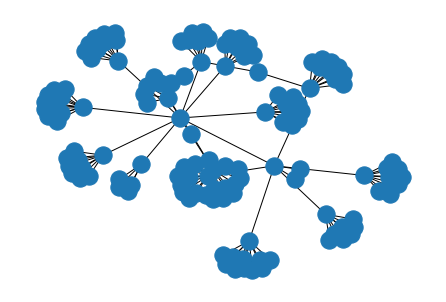

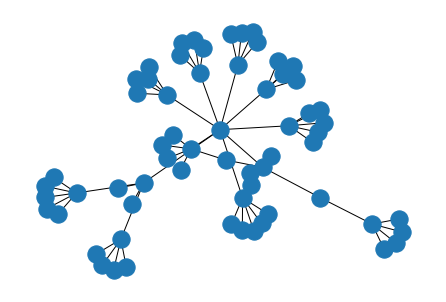

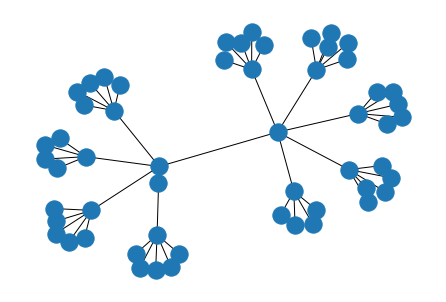



numero di nodi delle componenti giganti:
componente gigante 'generale':  134
componente gigante 'followers':  63
componente gigante 'friends':  55

id dei nodi che compongono le componenti giganti:
componente gigante 'generale':
 {1265795638551212032, 998681467696885761, 1400407060311851009, 1187585868493537280, 1440919645771337728, 1425660262653120517, 1020854242150453253, 1067977726118682625, 1207540011622490112, 1017826393676185600, 1455821652961398786, 923832978458869766, 31229962, 1440461778236829703, 740410382, 1448144596639252486, 1263591645489950727, 744516477554921472, 1443222435571113993, 1456403897036197899, 1462161558734348304, 393386006, 737333978462572544, 3223120420, 1443389966978007048, 3307967027, 59780150, 1495975003, 82774113, 19659370, 223439979, 2478451308, 1360376940, 1226387585133678592, 294599794, 524234866, 243190391, 1097014327289073664, 1315526823929876480, 1443842410040086528, 860108790645084160, 984803546741837824, 735447938214678529, 1078963404356767745,

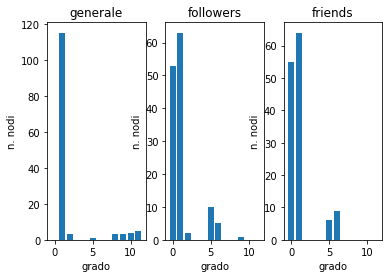

In [ ]:
#disegna rete
print("disegnare la rete")
tutor.genGraphs()
print("ok")
tutor.generalGraph.show("generalGraphP2.html")
tutor.followerGraph.show("followerGraphP2.html")
tutor.friendGraph.show("friendGraphP2.html")

#salvataggio dati raccolti in file json
print("salvataggio dei dati in json")
tutor.saveInfo()

#analisi dei grafici
print("analisi dei grafici")
tutor.analyzeGraphs()

#print dei risultati
print("\n\nnumero di nodi delle componenti giganti:")
print("componente gigante 'generale': ",tutor.bigComponentsLens[0])
print("componente gigante 'followers': ",tutor.bigComponentsLens[1])
print("componente gigante 'friends': ",tutor.bigComponentsLens[2])

print("\nid dei nodi che compongono le componenti giganti:")
print("componente gigante 'generale':\n",tutor.bigComponentGraphNodes[0])
print("\ncomponente gigante 'followers':\n",tutor.bigComponentGraphNodes[1])
print("\ncomponente gigante 'friends':\n",tutor.bigComponentGraphNodes[2])


In [ ]:
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=150, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

def istogramma(G, measure, measure_name, name_graph):
  lcc = measure(G)
  plt.hist(lcc.values(), bins=10)
  plt.title(name_graph)
  plt.xlabel(measure_name)
  plt.ylabel('Frequency')
  # plt.tight_layout()
  plt.show()



grafici sono fortemente/debolmente connessi: general, followers, friends
General:  False
Followers:  False
Friends:  False

i grafici sono bipartiti
General:  False
Followers:  True
Friends:  True

graphs degree distribution


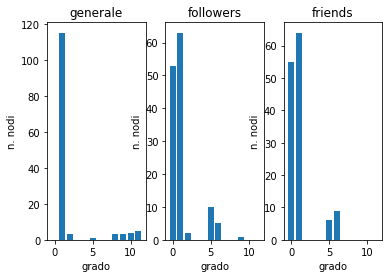


coefficente di clustering dei grafi
{18932422: 0, 15750573: 0, 998681467696885761: 0, 1369078711: 0, 1400407060311851009: 0, 1265795638551212032: 0, 740410382: 0, 1239642882: 0, 1425660262653120517: 0, 1020854242150453253: 0, 1187585868493537280: 0, 1455458703524700161: 0, 822006673267159040: 0, 2478451308: 0, 860108790645084160: 0, 700064764: 0, 778856886: 0, 19659370: 0, 82774113: 0, 249984650: 0, 59780150: 0, 1438395670432555008: 0, 45412709: 0, 353066446: 0, 15068044: 0, 748176824: 0, 1463970071160573955: 0, 1461555777072549891: 0, 3307967027: 0, 751326416495517697: 0, 975726033839296512: 0, 1395450619608113156: 0, 27946346: 0, 1431952888847294469: 0, 294599794: 0, 26711278: 0, 797564060392914944: 0, 1455821652961398786: 0, 506987932: 0, 76504000: 0, 233034691: 0, 1351202858629263361: 0, 42259133: 0, 394074504: 0, 70600594: 0, 1067977726118682625: 0, 1440919645771337728: 0, 250212498: 0, 1207540011622490112: 0, 2885659820: 0, 949744975855497216: 0, 1017826393676185600: 0, 39559166

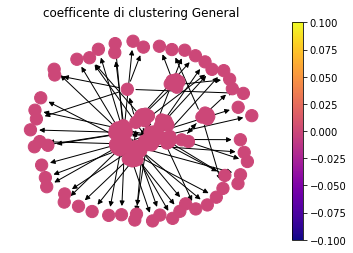

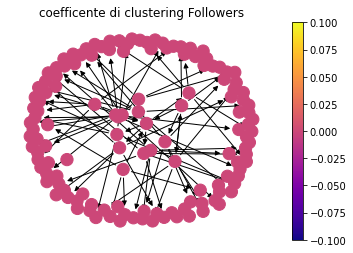

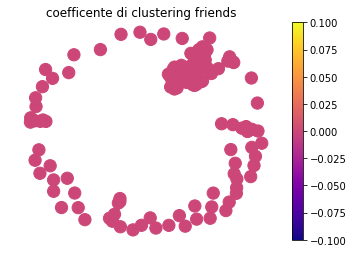

In [ ]:
print("grafici sono fortemente/debolmente connessi: general, followers, friends")
print("General: ",tutor.stronglyConnectedGraph[0])
print("Followers: ",tutor.stronglyConnectedGraph[1])
print("Friends: ",tutor.stronglyConnectedGraph[2])
print("")

print("i grafici sono bipartiti")
print("General: ",bipartite.is_bipartite(tutor.generalG))
print("Followers: ",bipartite.is_bipartite(tutor.followerG))
print("Friends: ",bipartite.is_bipartite(tutor.friendG))
print("")

print("graphs degree distribution")
tutor.drawDegreeDistributions()
print("")

# coefficiente di clustering dei grafi
print("coefficente di clustering dei grafi")
print(tutor.clustering) #nx.clustering(tutor.generalG) 
print(nx.clustering(tutor.followerG))
print(nx.clustering(tutor.friendG))
draw(
    tutor.generalG, 
    nx.spring_layout(tutor.generalG), 
    nx.clustering(tutor.generalG), 
    'coefficente di clustering General'
)
draw(
    tutor.followerG, 
    nx.spring_layout(tutor.followerG), 
    nx.clustering(tutor.followerG), 
    'coefficente di clustering Followers'
)
draw(
    tutor.friendG, 
    nx.spring_layout(tutor.friendG), 
    nx.clustering(tutor.friendG), 
    'coefficente di clustering friends'
)
print("")



In [ ]:
#distanze sui grafi
print("centro")
print("componente gigante 'generale':\n",tutor.bigComponentsCenterNodes[0])
print("componente gigante 'followers:\n",tutor.bigComponentsCenterNodes[1])
print("componente gigante 'friends:\n",tutor.bigComponentsCenterNodes[2])
print("")

print("raggio")
print("componente gigante 'generale':\n",tutor.bigComponentsRadius[0])
print("componente gigante 'followers':\n",tutor.bigComponentsRadius[1])
print("componente gigante 'friends':\n",tutor.bigComponentsRadius[2])
print("")

print("Distanza media")
print("componente gigante 'generale':\n",tutor.bigComponentsAverageDist[0])
print("componente gigante 'followers':\n",tutor.bigComponentsAverageDist[1])
print("componente gigante 'friends':\n",tutor.bigComponentsAverageDist[2])
print("")

print("Distanza massima") 
print("componente gigante 'generale':\n",tutor.bigComponentsMaxDist[0])
print("componente gigante 'followers':\n",tutor.bigComponentsMaxDist[1])
print("componente gigante 'friends':\n",tutor.bigComponentsMaxDist[2])
print("")


centro
componente gigante 'generale':
 [18932422, 15750573]
componente gigante 'followers:
 [1265795638551212032, 18932422]
componente gigante 'friends:
 [15750573, 18932422]

raggio
componente gigante 'generale':
 3
componente gigante 'followers':
 4
componente gigante 'friends':
 3

Distanza media
componente gigante 'generale':
 4.037257322410504
componente gigante 'followers':
 3.9344598054275473
componente gigante 'friends':
 3.8276094276094277

Distanza massima
componente gigante 'generale':
 5
componente gigante 'followers':
 7
componente gigante 'friends':
 5



Betweenness centrality
{18932422: 0.07575757575757576, 15750573: 0.05388471177944862, 998681467696885761: 0.01429710640236956, 1369078711: 0.015664160401002505, 1400407060311851009: 0.015379357484620642, 1265795638551212032: 0.013613579403053086, 740410382: 0.011392116655274549, 1239642882: 0.009398496240601503, 1425660262653120517: 0.009284575074048758, 1020854242150453253: 0.00934153565732513, 1187585868493537280: 0.009398496240601503, 1455458703524700161: 0.0, 822006673267159040: 0.014069264069264068, 2478451308: 0.008544087491455913, 860108790645084160: 0.0, 700064764: 0.013613579403053086, 778856886: 0.01367053998632946, 19659370: 0.01367053998632946, 82774113: 0.0, 249984650: 0.0, 59780150: 0.0, 1438395670432555008: 0.0, 45412709: 0.0, 353066446: 0.0, 15068044: 0.0, 748176824: 0.002050580997949419, 1463970071160573955: 0.0, 1461555777072549891: 0.0, 3307967027: 0.0, 751326416495517697: 0.0, 975726033839296512: 0.0, 1395450619608113156: 0.0, 27946346: 0.0, 1431952888847294469: 0.0

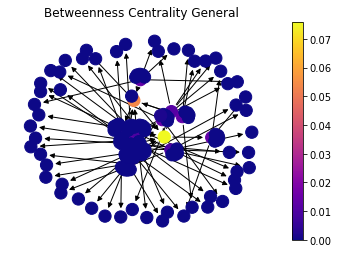

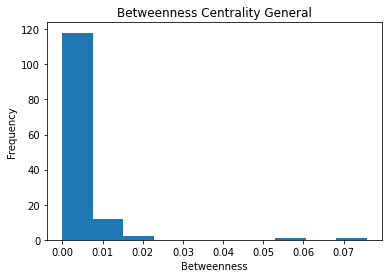

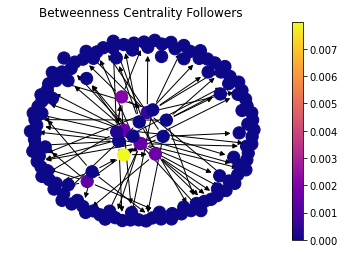

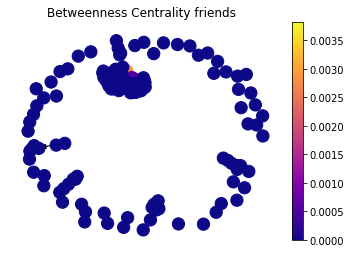


Closeness Centrality
{18932422: 0.1611842105263158, 15750573: 0.10071690855044588, 998681467696885761: 0.1412693223742586, 1369078711: 0.1361937778578182, 1400407060311851009: 0.1320771809040674, 1265795638551212032: 0.1361937778578182, 740410382: 0.11603081778520374, 1239642882: 0.03759398496240601, 1425660262653120517: 0.03759398496240601, 1020854242150453253: 0.03759398496240601, 1187585868493537280: 0.03759398496240601, 1455458703524700161: 0.06910659000442282, 822006673267159040: 0.07466943220119263, 2478451308: 0.09269749716757647, 860108790645084160: 0.06561859193438141, 700064764: 0.03759398496240601, 778856886: 0.03759398496240601, 19659370: 0.03759398496240601, 82774113: 0.10865874363327672, 249984650: 0.10578772512677041, 59780150: 0.10578772512677041, 1438395670432555008: 0.10865874363327672, 45412709: 0.12676427911884974, 353066446: 0.0, 15068044: 0.0, 748176824: 0.024606971975393025, 1463970071160573955: 0.10573518999291952, 1461555777072549891: 0.10573518999291952, 3307

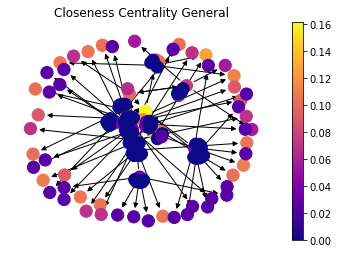

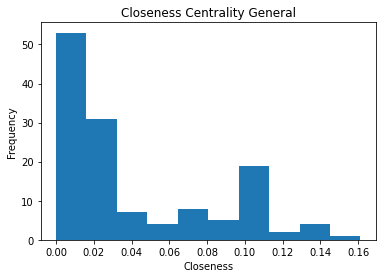

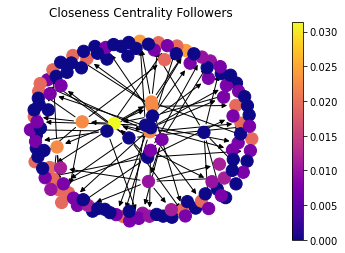

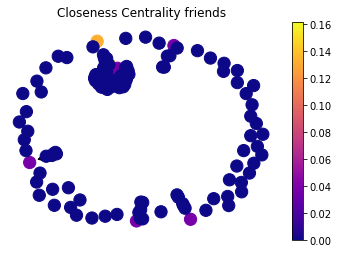


Degree centrality
{18932422: 0.07518796992481203, 15750573: 0.07518796992481203, 998681467696885761: 0.08270676691729323, 1369078711: 0.08270676691729323, 1400407060311851009: 0.07518796992481203, 1265795638551212032: 0.08270676691729323, 740410382: 0.03759398496240601, 1239642882: 0.07518796992481203, 1425660262653120517: 0.07518796992481203, 1020854242150453253: 0.07518796992481203, 1187585868493537280: 0.08270676691729323, 1455458703524700161: 0.007518796992481203, 822006673267159040: 0.07518796992481203, 2478451308: 0.08270676691729323, 860108790645084160: 0.015037593984962405, 700064764: 0.08270676691729323, 778856886: 0.08270676691729323, 19659370: 0.08270676691729323, 82774113: 0.007518796992481203, 249984650: 0.015037593984962405, 59780150: 0.015037593984962405, 1438395670432555008: 0.007518796992481203, 45412709: 0.015037593984962405, 353066446: 0.007518796992481203, 15068044: 0.007518796992481203, 748176824: 0.015037593984962405, 1463970071160573955: 0.007518796992481203, 14

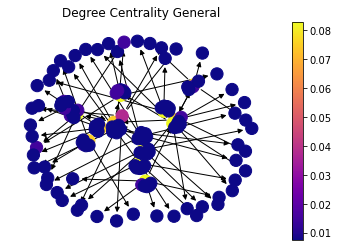

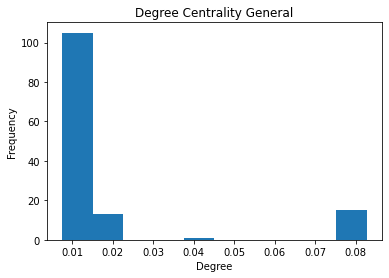


In-degree centrality
{18932422: 0.06766917293233082, 15750573: 0.045112781954887216, 998681467696885761: 0.045112781954887216, 1369078711: 0.045112781954887216, 1400407060311851009: 0.045112781954887216, 1265795638551212032: 0.045112781954887216, 740410382: 0.03759398496240601, 1239642882: 0.03759398496240601, 1425660262653120517: 0.03759398496240601, 1020854242150453253: 0.03759398496240601, 1187585868493537280: 0.03759398496240601, 1455458703524700161: 0.007518796992481203, 822006673267159040: 0.045112781954887216, 2478451308: 0.045112781954887216, 860108790645084160: 0.007518796992481203, 700064764: 0.03759398496240601, 778856886: 0.03759398496240601, 19659370: 0.03759398496240601, 82774113: 0.007518796992481203, 249984650: 0.007518796992481203, 59780150: 0.007518796992481203, 1438395670432555008: 0.007518796992481203, 45412709: 0.015037593984962405, 353066446: 0.0, 15068044: 0.0, 748176824: 0.007518796992481203, 1463970071160573955: 0.007518796992481203, 1461555777072549891: 0.007

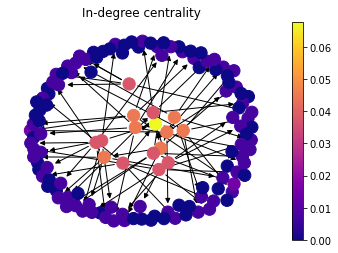


Out-degree centrality
{18932422: 0.045112781954887216, 15750573: 0.05263157894736842, 998681467696885761: 0.03759398496240601, 1369078711: 0.03759398496240601, 1400407060311851009: 0.03759398496240601, 1265795638551212032: 0.03759398496240601, 740410382: 0.0, 1239642882: 0.045112781954887216, 1425660262653120517: 0.045112781954887216, 1020854242150453253: 0.045112781954887216, 1187585868493537280: 0.045112781954887216, 1455458703524700161: 0.0, 822006673267159040: 0.045112781954887216, 2478451308: 0.03759398496240601, 860108790645084160: 0.007518796992481203, 700064764: 0.045112781954887216, 778856886: 0.045112781954887216, 19659370: 0.045112781954887216, 82774113: 0.0, 249984650: 0.007518796992481203, 59780150: 0.007518796992481203, 1438395670432555008: 0.0, 45412709: 0.0, 353066446: 0.007518796992481203, 15068044: 0.007518796992481203, 748176824: 0.007518796992481203, 1463970071160573955: 0.0, 1461555777072549891: 0.0, 3307967027: 0.0, 751326416495517697: 0.0, 975726033839296512: 0.

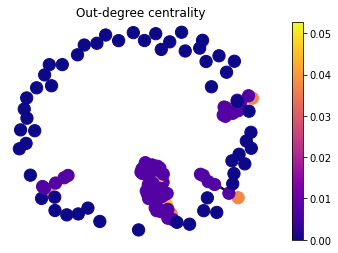


page rank dei grafi
General:  {18932422: 0.021147343838246832, 15750573: 0.021763262301126178, 998681467696885761: 0.03431098376849703, 1369078711: 0.022160376641247106, 1400407060311851009: 0.019154577469326584, 1265795638551212032: 0.031166904282679413, 740410382: 0.00713138078164448, 1239642882: 0.01856494880909908, 1425660262653120517: 0.026110739575061388, 1020854242150453253: 0.021700093398009646, 1187585868493537280: 0.01856494880909908, 1455458703524700161: 0.00723549341043159, 822006673267159040: 0.02251145576698274, 2478451308: 0.022264489270034216, 860108790645084160: 0.00723549341043159, 700064764: 0.021106023084240897, 778856886: 0.01856494880909908, 19659370: 0.01856494880909908, 82774113: 0.009367450612484993, 249984650: 0.009367450612484993, 59780150: 0.009367450612484993, 1438395670432555008: 0.009367450612484993, 45412709: 0.01466449063016933, 353066446: 0.0035359529494964513, 15068044: 0.0035359529494964513, 748176824: 0.00616545857642684, 1463970071160573955: 0.007

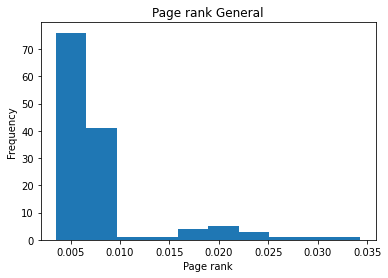

Followers:  {18932422: 0.011434495929621577, 15750573: 0.008033725716697483, 998681467696885761: 0.00861154203187583, 1369078711: 0.00861154203187583, 1400407060311851009: 0.00861154203187583, 1265795638551212032: 0.00861154203187583, 740410382: 0.00861154203187583, 1239642882: 0.006668024034888081, 1425660262653120517: 0.006668024034888081, 1020854242150453253: 0.006668024034888081, 1187585868493537280: 0.006668024034888081, 1455458703524700161: 0.008033725716697483, 822006673267159040: 0.008033725716697483, 2478451308: 0.008033725716697483, 860108790645084160: 0.008033725716697483, 700064764: 0.006668024034888081, 778856886: 0.006668024034888081, 19659370: 0.006668024034888081, 82774113: 0.008132264500040183, 249984650: 0.008132264500040183, 59780150: 0.008132264500040183, 1438395670432555008: 0.008132264500040183, 45412709: 0.009596504965192284, 353066446: 0.006668024034888081, 15068044: 0.006668024034888081, 748176824: 0.00780161410586278, 1463970071160573955: 0.008132264500040183,

In [ ]:
# misure di centralità sui grafi:
print("Betweenness centrality")
print(tutor.betweennessCentralityGeneral)
print(tutor.betweennessCentralityFollowers)
print(tutor.betweennessCentralityFriends)
draw(
    tutor.generalG, 
    nx.spring_layout(tutor.generalG), 
    nx.betweenness_centrality(tutor.generalG), 
    'Betweenness Centrality General'
)
istogramma(tutor.generalG,
           nx.betweenness_centrality,
           "Betweenness",
           "Betweenness Centrality General" )
draw(
    tutor.followerG, 
    nx.spring_layout(tutor.followerG), 
    nx.betweenness_centrality(tutor.followerG), 
    'Betweenness Centrality Followers'
)
draw(
    tutor.friendG, 
    nx.spring_layout(tutor.friendG), 
    nx.betweenness_centrality(tutor.friendG), 
    'Betweenness Centrality friends'
)
print("")


print("Closeness Centrality")
print(tutor.closenessCentralityGeneral)
print(tutor.closenessCentralityFollowers)
print(tutor.closenessCentralityFriends)
draw(
    tutor.generalG, 
    nx.spring_layout(tutor.generalG), 
    nx.closeness_centrality(tutor.generalG), 
    'Closeness Centrality General'
)
istogramma(tutor.generalG,
           nx.closeness_centrality,
           "Closeness",
           "Closeness Centrality General" )
draw(
    tutor.followerG, 
    nx.spring_layout(tutor.followerG), 
    nx.closeness_centrality(tutor.followerG), 
    'Closeness Centrality Followers'
)
draw(
    tutor.friendG, 
    nx.spring_layout(tutor.friendG), 
    nx.closeness_centrality(tutor.friendG), 
    'Closeness Centrality friends'
)
print("") 


print("Degree centrality")
print(nx.degree_centrality(tutor.generalG))  
draw(
    tutor.generalG, 
    nx.spring_layout(tutor.generalG), 
    nx.degree_centrality(tutor.generalG), 
    'Degree Centrality General'
)
istogramma(tutor.generalG,
           nx.degree_centrality,
           "Degree",
           "Degree Centrality General" )
print("")

print("In-degree centrality")
print(nx.degree_centrality(tutor.followerG))
draw(
    tutor.followerG, 
    nx.spring_layout(tutor.followerG), 
    nx.degree_centrality(tutor.followerG), 
    'In-degree centrality'
)
print("")

print("Out-degree centrality")
print(nx.degree_centrality(tutor.friendG))
draw(
    tutor.friendG, 
    nx.spring_layout(tutor.friendG), 
    nx.degree_centrality(tutor.friendG), 
    'Out-degree centrality'
)
print("")


print("page rank dei grafi")
print("General: ",tutor.pagerankGeneral)
istogramma(tutor.generalG,
           nx.pagerank,
           "Page rank",
           "Page rank General" )
print("Followers: ",nx.pagerank(tutor.followerG))
print("Friends: ",nx.pagerank(tutor.friendG))
print("")


print("HITS")
print("hubness")
print(tutor.hubness)
print("authority")
print(tutor.authority)
print("")


print("coefficienti per stimare la “small-world-ness” dei grafi")
print("coefficienti omega e sigma delle componenti giganti:")
print("componente gigante 'generale': ",tutor.omegaCoefficients[0],tutor.sigmaCoefficients[0])
print("componente gigante 'followers': ",tutor.omegaCoefficients[1],tutor.sigmaCoefficients[1])
print("componente gigante 'friends': ",tutor.omegaCoefficients[2],tutor.sigmaCoefficients[2])
print("")


In [ ]:
# Calcolare le correlazioni di Pearson e Kendall fra le misure di centralità; riportare il risultato in due tabelle

#PEARSON
nomi = ["/" ,"betweenness", "closeness", "degree", "in-degree", "out-degree"]
nomi2 = ["betweenness", "closeness", "degree", "in-degree", "out-degree"]

x = nx.betweenness_centrality(tutor.generalG)
between = [x[element] for element in x]
a = nx.closeness_centrality(tutor.generalG)
close = [a[element] for element in a]
b = nx.degree_centrality(tutor.generalG)
degree = [b[element] for element in b]
c = nx.degree_centrality(tutor.followerG)
in_deg = [c[element] for element in c]
d = nx.degree_centrality(tutor.friendG)
out_deg = [d[element] for element in d]


bet = [stats.pearsonr(between, between)[0], stats.pearsonr(between, close)[0], stats.pearsonr(between, degree)[0], stats.pearsonr(between, in_deg)[0], stats.pearsonr(between, out_deg)[0]]
clo = [stats.pearsonr(close, between)[0], stats.pearsonr(close, close)[0], stats.pearsonr(close, degree)[0], stats.pearsonr(close, in_deg)[0], stats.pearsonr(close, out_deg)[0]]
deg = [stats.pearsonr(degree, between)[0], stats.pearsonr(degree, close)[0], stats.pearsonr(degree, degree)[0], stats.pearsonr(degree, in_deg)[0], stats.pearsonr(degree, out_deg)[0]]
in_d = [stats.pearsonr(in_deg, between)[0], stats.pearsonr(in_deg, close)[0], stats.pearsonr(in_deg, degree)[0], stats.pearsonr(in_deg, in_deg)[0], stats.pearsonr(in_deg, out_deg)[0]]
out_d = [stats.pearsonr(out_deg, between)[0], stats.pearsonr(out_deg, close)[0], stats.pearsonr(out_deg, degree)[0], stats.pearsonr(out_deg, in_deg)[0], stats.pearsonr(out_deg, out_deg)[0]]


fig = go.Figure(data=[go.Table(
    header=dict(values= nomi,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values= [nomi2, bet, clo, deg, in_d, out_d],
               fill_color='lavender',
               align='left'))
])

fig.show()


In [ ]:
# KENDALL
nomi = ["/" ,"betweenness", "closeness", "degree", "in-degree", "out-degree"]
nomi2 = ["betweenness", "closeness", "degree", "in-degree", "out-degree"]

x = nx.betweenness_centrality(tutor.generalG)
between = [x[element] for element in x]
a = nx.closeness_centrality(tutor.generalG)
close = [a[element] for element in a]
b = nx.degree_centrality(tutor.generalG)
degree = [b[element] for element in b]
c = nx.degree_centrality(tutor.followerG)
in_deg = [c[element] for element in c]
d = nx.degree_centrality(tutor.friendG)
out_deg = [d[element] for element in d]


bet = [stats.kendalltau(between, between)[0], stats.kendalltau(between, close)[0], stats.kendalltau(between, degree)[0], stats.kendalltau(between, in_deg)[0], stats.kendalltau(between, out_deg)[0]]
clo = [stats.kendalltau(close, between)[0], stats.kendalltau(close, close)[0], stats.kendalltau(close, degree)[0], stats.kendalltau(close, in_deg)[0], stats.kendalltau(close, out_deg)[0]]
deg = [stats.kendalltau(degree, between)[0], stats.kendalltau(degree, close)[0], stats.kendalltau(degree, degree)[0], stats.kendalltau(degree, in_deg)[0], stats.kendalltau(degree, out_deg)[0]]
in_d = [stats.kendalltau(in_deg, between)[0], stats.kendalltau(in_deg, close)[0], stats.kendalltau(in_deg, degree)[0], stats.kendalltau(in_deg, in_deg)[0], stats.kendalltau(in_deg, out_deg)[0]]
out_d = [stats.kendalltau(out_deg, between)[0], stats.kendalltau(out_deg, close)[0], stats.kendalltau(out_deg, degree)[0], stats.kendalltau(out_deg, in_deg)[0], stats.kendalltau(out_deg, out_deg)[0]]


fig = go.Figure(data=[go.Table(
    header=dict(values= nomi,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values= [nomi2, bet, clo, deg, in_d, out_d],
               fill_color='lavender',
               align='left'))
])

fig.show()
